In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
path_to_db='../../ESC-50/'
audio_dir = path_to_db + 'audio/'
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [7]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [8]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_target)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return np.array(items)

Overwriting load_blockwise.py


In [9]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2498.42 MiB, increment: 2194.20 MiB
CPU times: user 4min 26s, sys: 1.83 s, total: 4min 28s
Wall time: 4min 28s


In [10]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1788.63 MiB, increment: 490.43 MiB
CPU times: user 1min 6s, sys: 540 ms, total: 1min 6s
Wall time: 1min 6s


In [11]:
train_y = np.vstack([train_y, train_yy]).T
test_y = np.vstack([test_y, test_yy]).T

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [12]:
%%file cnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, InputLayer
from kapre.time_frequency import Melspectrogram, Spectrogram

from keras.wrappers.scikit_learn import KerasClassifier

SR=16000

class CNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=128, validation_split=0.05,
                       a_epochs=50, a_batch_size=128,
                       i_epochs=50, i_batch_size=128,
                       verbose=1):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
#         print(X.shape)
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=SR * 5,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=SR * 5,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=SR * 5,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        for x in X:
            prob = self.clf.predict_proba(x, verbose=0).squeeze()
#             print(prob)
            if prob[0] > 0.75:
                pred = self.a_clf.predict(x, verbose=0).squeeze()
            elif prob[1] > 0.75:
                pred = self.i_clf.predict(x, verbose=0).squeeze()
            else:
                a_pred = self.a_clf.predict(x, verbose=0).squeeze()
                i_pred = self.i_clf.predict(x, verbose=0).squeeze()
                
                a_prob = self.a_clf.predict_proba(x, verbose=0).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x, verbose=0).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()
#         print(prob)

        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze(),prob[0])
#         print(prob_a)

        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze(),prob[1])
#         print(prob_i)
#         print()
        
        probs = [None] * 50
        for counter, j in enumerate(self.a_clf.classes_):
            probs[j] = prob_a[counter]
        for counter, j in enumerate(self.i_clf.classes_):
            probs[j] = prob_i[counter]
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        model.summary()


        return model

    def deep_net_a(self, feature_count):
        # Create Model
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(19, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(31, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting cnnmult.py


In [13]:
from cnnmult import CNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

clf = CNN_Multilayer()

clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

1520/1520 [==============================] - 44s 29ms/step - loss: 0.1276 - acc: 0.9559 - val_loss: 0.9193 - val_acc: 0.8000
Epoch 48/50
1520/1520 [==============================] - 42s 28ms/step - loss: 0.1197 - acc: 0.9632 - val_loss: 1.0381 - val_acc: 0.8125
Epoch 49/50
1520/1520 [==============================] - 42s 27ms/step - loss: 0.1362 - acc: 0.9474 - val_loss: 1.7027 - val_acc: 0.7125
Epoch 50/50
1520/1520 [==============================] - 43s 28ms/step - loss: 0.1569 - acc: 0.9428 - val_loss: 0.9151 - val_acc: 0.8000
Train on 577 samples, validate on 31 samples
Epoch 1/50
577/577 [==============================] - 17s 29ms/step - loss: 2.9396 - acc: 0.0433 - val_loss: 2.9380 - val_acc: 0.0000e+00
Epoch 2/50
577/577 [==============================] - 16s 28ms/step - loss: 2.9071 - acc: 0.0676 - val_loss: 2.9106 - val_acc: 0.0323
Epoch 3/50
577/577 [==============================] - 16s 28ms/step - loss: 2.8612 - acc: 0.0797 - val_loss: 2.8814 - val_acc: 0.0000e+00
Epoch 4/5

942/942 [==============================] - 26s 27ms/step - loss: 3.1531 - acc: 0.0817 - val_loss: 3.2304 - val_acc: 0.0200
Epoch 8/50
942/942 [==============================] - 27s 29ms/step - loss: 3.1282 - acc: 0.0828 - val_loss: 3.2173 - val_acc: 0.0200
Epoch 9/50
942/942 [==============================] - 27s 28ms/step - loss: 3.0945 - acc: 0.1136 - val_loss: 3.1836 - val_acc: 0.0200
Epoch 10/50
942/942 [==============================] - 27s 28ms/step - loss: 3.0966 - acc: 0.1178 - val_loss: 3.1231 - val_acc: 0.0400
Epoch 11/50
942/942 [==============================] - 26s 28ms/step - loss: 3.0418 - acc: 0.1316 - val_loss: 3.1072 - val_acc: 0.0200
Epoch 12/50
942/942 [==============================] - 26s 28ms/step - loss: 3.0123 - acc: 0.1338 - val_loss: 3.1074 - val_acc: 0.0800
Epoch 13/50
942/942 [==============================] - 27s 28ms/step - loss: 2.9774 - acc: 0.1497 - val_loss: 3.0710 - val_acc: 0.0800
Epoch 14/50
942/942 [==============================] - 26s 28ms/step 

CNN_Multilayer(a_batch_size=128, a_epochs=50, batch_size=128, epochs=50,
        i_batch_size=128, i_epochs=50, validation_split=0.05, verbose=1)

In [14]:
print(test_X[:, np.newaxis, :, :].shape)

(400, 1, 1, 80000)


0.2875
Confusion matrix, without normalization
[[2 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


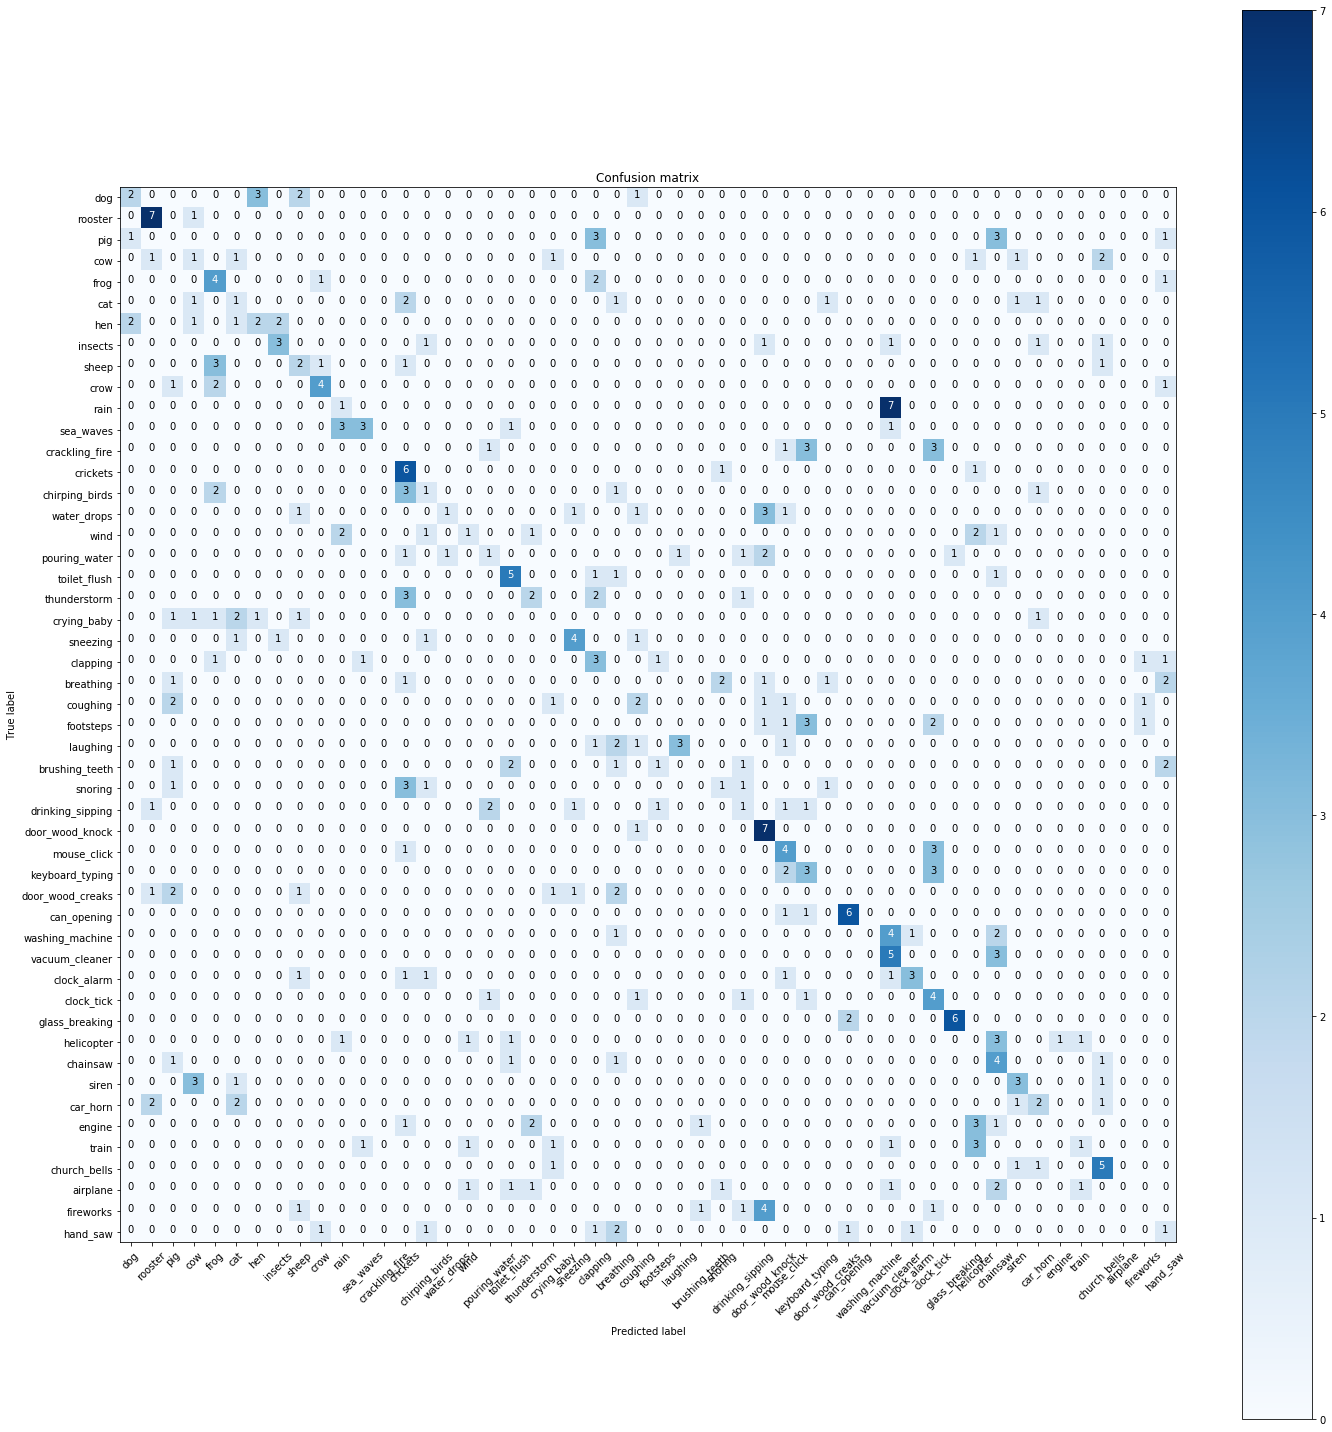

In [15]:
pred = clf.predict(test_X[:, np.newaxis, :, :])
print(metrics.accuracy_score(test_y[:,1], pred))
cm = metrics.confusion_matrix(test_y[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [16]:
%%time
import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

test = dataset[dataset.fold == 1].reset_index()
    
for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



	File Time: 0.21883678436279297
	File Time: 0.22440338134765625
	File Time: 0.22168302536010742
	File Time: 0.19607234001159668
	File Time: 0.21891999244689941
	File Time: 0.2404477596282959
	File Time: 0.24030017852783203
	File Time: 0.2531931400299072
	File Time: 0.2343740463256836
	File Time: 0.24531817436218262
	File Time: 0.23866915702819824
	File Time: 0.21298718452453613
	File Time: 0.21102118492126465
	File Time: 0.23163485527038574
	File Time: 0.2857930660247803
	File Time: 0.20984864234924316
	File Time: 0.24449968338012695
	File Time: 0.23379755020141602
	File Time: 0.26914262771606445
	File Time: 0.21680188179016113
	File Time: 0.2544572353363037
	File Time: 0.25177717208862305
	File Time: 0.21955275535583496
	File Time: 0.2267146110534668
	File Time: 0.22018718719482422
	File Time: 0.18763041496276855
	File Time: 0.2304701805114746
	File Time: 0.28418660163879395
	File Time: 0.23458027839660645
	File Time: 0.22391748428344727
	File Time: 0.26776623725891113
	File Time: 0.2

	File Time: 0.19598126411437988
	File Time: 0.25893115997314453
	File Time: 0.2281663417816162
	File Time: 0.2923166751861572
	File Time: 0.2723517417907715
	File Time: 0.26360321044921875
	File Time: 0.22914457321166992
	File Time: 0.2090167999267578
	File Time: 0.2089540958404541
	File Time: 0.24539852142333984
	File Time: 0.24193668365478516
	File Time: 0.27567553520202637
	File Time: 0.23915767669677734
	File Time: 0.24605870246887207
	File Time: 0.21482181549072266
	File Time: 0.25655555725097656
	File Time: 0.22751379013061523
	File Time: 0.2536160945892334
	File Time: 0.21956253051757812
	File Time: 0.22072649002075195
	File Time: 0.2502021789550781
	File Time: 0.23715472221374512
	File Time: 0.26515746116638184
	File Time: 0.2835838794708252
	File Time: 0.21923422813415527
	File Time: 0.23935627937316895
	File Time: 0.20853424072265625
	File Time: 0.268312931060791
	File Time: 0.22973108291625977
	File Time: 0.20831632614135742
	File Time: 0.21171855926513672
	File Time: 0.1786

0.2875
0.2691330867200432
Confusion matrix, without normalization
[[2 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


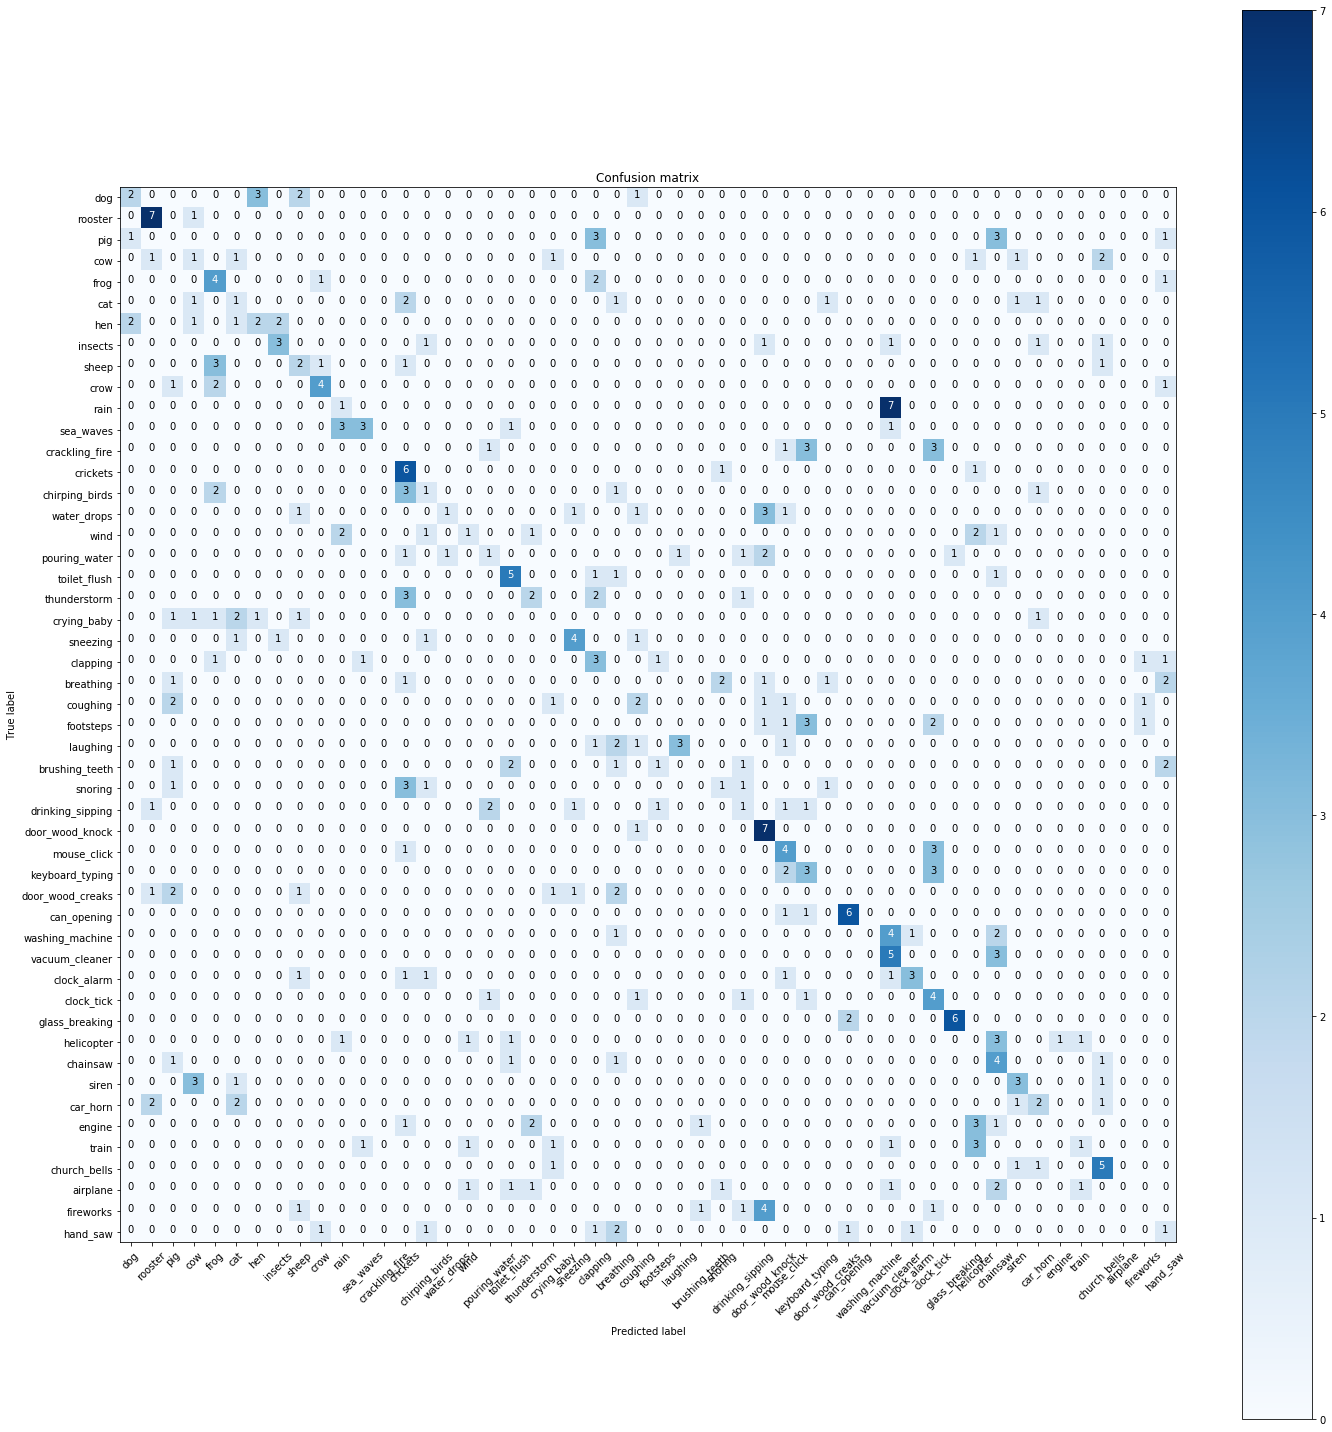

In [17]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [18]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)
    
    predictions = []

    for data_iloc in range(0,len(test)):
        x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                             blocksize=orig_blocksize,
                             overlap=orig_overlap)[0]

#         print(clf.predict_proba(x_file).shape)
        
        prob = clf.predict_proba(x_file)[l_l]
        pred = clf.predict(x_file[np.newaxis, :, :, :])
        
        predictions.append({
            'file': test.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': prob,
            'prediction': pred
        })
        
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    return predictions

In [19]:
%%time
preds = query_dataset('dog')

CPU times: user 7min 52s, sys: 2min 20s, total: 10min 13s
Wall time: 1min 47s


In [20]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
#     print(misclass)
    return (count - len(misclass))/count

In [21]:
# Checking index
check_accuracy(preds, 'dog', 10)

0.2

In [ ]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 6min 52s, sys: 2min 52s, total: 9min 45s
Wall time: 1min 48s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.46 ms
dog
0.2

CPU times: user 6min 48s, sys: 3min 2s, total: 9min 50s
Wall time: 1min 48s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 9.81 ms
rooster
0.6

CPU times: user 6min 41s, sys: 3min 3s, total: 9min 44s
Wall time: 1min 49s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.94 ms
pig
0.1

CPU times: user 6min 51s, sys: 2min 50s, total: 9min 41s
Wall time: 1min 51s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.24 ms
cow
0.1

CPU times: user 6min 45s, sys: 3min, total: 9min 45s
Wall time: 1min 50s
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.43 ms
frog
0.4

CPU times: user 6min 47s, sys: 2min 49s, total: 9min 36s
Wall time: 1min 49s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.85 ms
cat
0.1

